In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess
import matplotlib.pyplot as plt

In [39]:
EXECUTABLES_DIR = '../bin'
ALGORITHM_FILENAME = 'cvrp_cws'
INSTANCE_FILENAME = 'X-n502-k39'
INSTANCE_FILEPATH = 'instancias/%s.txt' % INSTANCE_FILENAME


In [40]:
def ruta_instancia(instancia):
    return INSTANCE_FILEPATH

# Creo el archivo levantando los parámetros de la instancia que me son relevantes
def crear_instancia(instancia):
    file_name = 'instancias/corridas/%s.txt' % (instancia)
    output_file = open(file_name, 'w')
    
    input_file = open(ruta_instancia(instancia), 'r')
    
    lines = input_file.readlines()
    # number of vertex in graph
    v_size = int(lines[3].split()[2])
    output_file.write(str(v_size)+ '\n')
    # capacity of each truck
    output_file.write(lines[5].split()[2] + '\n')
    # cordenates of vertex in euclidean space
    for index in range(7, 7+v_size):
        output_file.write(lines[index])
    # objective capacity of vertex
    for index in range(7+v_size+1, 7+v_size+1+v_size):
        output_file.write(lines[index])

    input_file.close()
    output_file.close()
    return file_name

In [41]:
# Creo un DataFrame con la instancia pedida
def cargar_informacion(nombre_instancia):
    matrix_data = []
    archivo_instancia = open(nombre_instancia, 'rb')
    
    lines = archivo_instancia.readlines()
    # number of vertex in graph
    v_size = int(lines[0])
    # camiones
    truck_size = int(lines[1])
    # cordenates of vertex in euclidean space
    for index in range(2, 2+v_size):
        line = lines[index].split()
        matrix_data.append( [int(line[0]), int(line[1]) ,int(line[2]) ,0, truck_size, v_size])
    # objective capacity of vertex
    for index in range(2+v_size, 2+v_size+v_size):
        line = lines[index].split()
        vertex = int(line[0])
        objective = int(line[1])
        matrix_data[vertex-1][3] = objective
        
    archivo_instancia.close()
    return pd.DataFrame(matrix_data, columns=['numero_punto','x', 'y','objetivo','truck_amount','vertex_amount'])

In [42]:
# Corro el $algoritmo (ejecutable) para el input del $archivo
def correr_instancia(dataframe, algoritmo,file_name):
    input_data = str(dataframe.loc[dataframe.numero_punto == 1, 'vertex_amount'].values[0]) + '\n' 
    input_data = input_data + str(dataframe.loc[dataframe.numero_punto == 1, 'truck_amount'].values[0]) + '\n' 
    input_data = input_data + dataframe[['x', 'y','objetivo']].to_csv(header=False,index=False,sep=' ',line_terminator='\n')
    
    output_file = open(file_name, 'w')
    output_file.write(input_data)
    output_file.close()
    
    try:
        result = subprocess.run(["{0}/{1}".format(EXECUTABLES_DIR, algoritmo)], stdout=subprocess.PIPE, input=str.encode(input_data))
    except subprocess.CalledProcessError as e:
        Raise ("Algorithm ERROR {}".format(e.output))
    results = result.stdout.decode("utf-8").split('\n')
    results.pop(len(results) -1)
    return results

def lista_de(lista,tipo):
    return list(map(lambda valor : tipo(valor),lista))

In [43]:
def parsear_y_guardar(dataframe, listas):
    camiones = int(listas[0])
    dataframe['result'] = int(listas[camiones+1])
    dataframe['caminos'] = 0
   
    # Elijo un cluster para cada camimno
    indice_grupo = 1
    for index in range(camiones):
        caminos = map(lambda x : int(x), listas[indice_grupo].split())
        for parada in caminos:
            dataframe.loc[dataframe.numero_punto == parada, 'caminos'] = indice_grupo
        indice_grupo = indice_grupo + 1
          
#     El primero está en todos los caminos así que mejor lo saco de todos.
    dataframe.loc[dataframe.numero_punto == 1, 'caminos'] = 0
    
    
    return dataframe
    

In [44]:
# Englobo todas las funciones y devuelvo un DataFrame con la instancia y los clusters calculados
def calcular_y_graficar(instancia, ejecutable):
    file_name = crear_instancia(instancia)
    dataframe = cargar_informacion(file_name)
    results = correr_instancia(dataframe, ejecutable, file_name)
    dataframe = parsear_y_guardar(dataframe, results)
    return dataframe

## Correr una instancia con parámetros

In [45]:
dataframe = calcular_y_graficar(INSTANCE_FILENAME, ALGORITHM_FILENAME)
dataframe

,numero_punto,x,y,objetivo,truck_amount,vertex_amount,result,caminos
0,1,0,0,0,13,502,71135,0
1,2,159,917,1,13,502,71135,1
2,3,635,200,1,13,502,71135,39
3,4,278,907,1,13,502,71135,13
4,5,667,141,1,13,502,71135,22
5,6,119,954,1,13,502,71135,8
6,7,29,448,1,13,502,71135,18
7,8,590,87,1,13,502,71135,30
8,9,375,990,1,13,502,71135,3
9,10,511,374,1,13,502,71135,36


## Graficar la instancia anterior

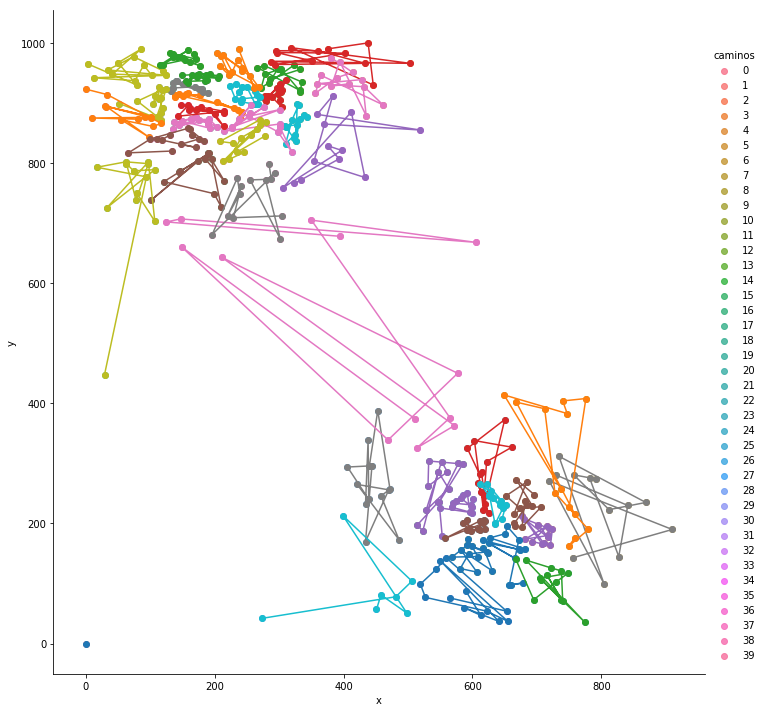

In [46]:
sns.lmplot(data=dataframe,x='x',y='y',hue='caminos',fit_reg=False, legend=True, legend_out=True,height=10)
for key,grp in dataframe.groupby('caminos'):
    plt.plot(grp.x,grp.y,'o-',label = key)


# Graficar otra instancia

In [47]:
dataframe = calcular_y_graficar('X-n502-k39.txt', 'savings-main')
dataframe

FileNotFoundError: [Errno 2] No such file or directory: '../bin/savings-main': '../bin/savings-main'